<a href="https://colab.research.google.com/github/dareabioye/dareabioye/blob/main/Confectionary_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px

sns.set_style("whitegrid")
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [30]:
# Cell 2: Load data
FILE = "/content/Confectionary [4564].xlsx"   # <-- ensure this file is in the same folder
df_raw = pd.read_excel(FILE, sheet_name="Sheet1")
df_raw.info()
display(df_raw.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1001 non-null   datetime64[ns]
 1   Country(UK)    1001 non-null   object        
 2   Confectionary  1001 non-null   object        
 3   Units Sold     996 non-null    float64       
 4   Cost(£)        992 non-null    float64       
 5   Profit(£)      998 non-null    float64       
 6   Revenue(£)     1001 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 54.9+ KB


,Date,Country(UK),Confectionary,Units Sold,Cost(£),Profit(£),Revenue(£)
0,2002-11-11,England,Biscuit,1118.0,2459.6,3130.4,749954.4
1,2002-07-05,England,Biscuit,708.0,1557.6,1982.4,300758.4
2,2001-10-31,England,Biscuit,1269.0,2791.8,3553.2,966216.6
3,2004-09-13,England,Biscuit,1631.0,3588.2,4566.8,1596096.6
4,2004-03-10,England,Biscuit,2240.0,4928.0,6272.0,3010560.0


In [31]:
# Cell 3: Initial checks (missing, zeros, negatives, identity)
print("Shape:", df_raw.shape)
print("\nMissing values per column:\n", df_raw.isna().sum())
print("\nUnique values per column:\n", df_raw.nunique())
print("\nZero counts per column:\n", (df_raw == 0).sum())
print("\nNegative counts per column:\n", (df_raw.select_dtypes(include=np.number) < 0).sum())

# Quick identity check: Revenue vs Cost + Profit
# Coerce numeric and compute
for col in ["Units Sold","Cost(£)","Profit(£)","Revenue(£)"]:
    df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

df_raw["cost_plus_profit"] = df_raw["Cost(£)"] + df_raw["Profit(£)"]
df_raw["rev_minus_cplusp"] = df_raw["Revenue(£)"] - df_raw["cost_plus_profit"]

inconsistent_mask = df_raw["cost_plus_profit"].notna() & (df_raw["rev_minus_cplusp"].abs() > (0.01 * df_raw["Revenue(£)"].abs() + 1.0))
print("Inconsistent rows (Revenue != Cost+Profit):", inconsistent_mask.sum(), "of", len(df_raw))

# Show sample problematic rows
display(df_raw.loc[inconsistent_mask].head(10))

Shape: (1001, 7)

Missing values per column:
 Date             0
Country(UK)      0
Confectionary    0
Units Sold       5
Cost(£)          9
Profit(£)        3
Revenue(£)       0
dtype: int64

Unique values per column:
 Date             802
Country(UK)        5
Confectionary      8
Units Sold       391
Cost(£)          513
Profit(£)        511
Revenue(£)       499
dtype: int64

Zero counts per column:
 Date             0
Country(UK)      0
Confectionary    0
Units Sold       0
Cost(£)          0
Profit(£)        0
Revenue(£)       5
dtype: int64

Negative counts per column:
 Units Sold    0
Cost(£)       0
Profit(£)     0
Revenue(£)    3
dtype: int64
Inconsistent rows (Revenue != Cost+Profit): 989 of 1001


,Date,Country(UK),Confectionary,Units Sold,Cost(£),Profit(£),Revenue(£),cost_plus_profit,rev_minus_cplusp
0,2002-11-11,England,Biscuit,1118.0,2459.6,3130.4,749954.4,5590.0,744364.4
1,2002-07-05,England,Biscuit,708.0,1557.6,1982.4,300758.4,3540.0,297218.4
2,2001-10-31,England,Biscuit,1269.0,2791.8,3553.2,966216.6,6345.0,959871.6
3,2004-09-13,England,Biscuit,1631.0,3588.2,4566.8,1596096.6,8155.0,1587941.6
4,2004-03-10,England,Biscuit,2240.0,4928.0,6272.0,3010560.0,11200.0,2999360.0
5,2004-05-29,England,Biscuit,3521.0,7746.2,9858.8,7438464.6,17605.0,7420859.6
6,2000-10-30,England,Biscuit,707.0,1555.4,1979.6,299909.4,3535.0,296374.4
7,2005-04-30,England,Biscuit,2734.0,6014.8,7655.2,4484853.6,13670.0,4471183.6
8,2002-03-09,England,Biscuit,1659.0,3649.8,4645.2,1651368.6,8295.0,1643073.6
9,2000-08-05,England,Biscuit,888.0,1953.6,2486.4,473126.4,4440.0,468686.4


In [47]:
# Cell 4: Deciding correction strategy (will be documented) and apply it
# Revenue will be corrected  by setting Revenue_corrected = Cost + Profit (row totals).
# Drop rows where Cost or Profit is missing (cannot reconstruct revenue)
df = df_raw.copy()
before_rows = len(df)
df = df.dropna(subset=["Cost(£)","Profit(£)"])
dropped = before_rows - len(df)
print(f"Dropped {dropped} rows because Cost or Profit was missing.")

df["Revenue_Corrected"] = df["Cost(£)"] + df["Profit(£)"]

# Impute Units Sold with median for a tiny number of missing entries (documented)
if df["Units Sold"].isna().sum() > 0:
    median_units = df["Units Sold"].median()
    df["Units Sold"] = df["Units Sold"].fillna(median_units)
    print(f"Imputed {df['Units Sold'].isna().sum()} Units Sold with median={median_units}")

# Standardize Confectionary names
df["Confectionary"] = df["Confectionary"].str.lower().str.strip()
df["Confectionary"] = df["Confectionary"].replace({
    "choclate chunk": "chocolate chunk",
    "caramel nut": "caramel nut"
})
print(f"Standardized Confectionary names. New unique count: {df['Confectionary'].nunique()}")

# Derived features
df["Unit_Price"] = df["Revenue_Corrected"] / df["Units Sold"]
df["Cost_per_Unit"] = df["Cost(£)"] / df["Units Sold"]
df["Profit_per_Unit"] = df["Profit(£)"] / df["Units Sold"]
df["Profit_Margin"] = df["Profit(£)"] / df["Revenue_Corrected"]

# Check new identity
df["rev_minus_recalc"] = df["Revenue_Corrected"] - (df["Cost(£)"] + df["Profit(£)"])
print("Max difference after recalculation:", df["rev_minus_recalc"].abs().max())

Dropped 12 rows because Cost or Profit was missing.
Imputed 0 Units Sold with median=1530.5
Standardized Confectionary names. New unique count: 6
Max difference after recalculation: 0.0


In [48]:
# Cell 5: Summary statistics post-cleaning
display(df[["Units Sold","Cost(£)","Profit(£)","Revenue_Corrected","Unit_Price","Profit_Margin"]].describe().T)


,count,mean,std,min,25%,50%,75%,max
Units Sold,989.0,1633.077351,873.352374,200.000000,941.00,1530.5,2300.000,4493.000000
Cost(£),989.0,2817.019869,2070.080086,40.000000,1204.00,2454.0,3968.000,10994.500000
Profit(£),989.0,4022.535238,2654.164072,160.000000,1872.00,3460.8,5452.500,13479.000000
Revenue_Corrected,989.0,6839.555106,4695.077829,200.000000,2972.00,5950.0,9505.000,23988.000000
Unit_Price,989.0,4.204254,1.537646,0.500490,3.00,5.0,5.000,10.800392
Profit_Margin,989.0,0.610762,0.076246,0.541667,0.56,0.6,0.625,0.800000


In [49]:
# Cell 6: Save cleaned CSV
df.to_csv(os.path.join(OUT_DIR, "Confectionary_cleaned.csv"), index=False)
print("Saved cleaned CSV to outputs/Confectionary_cleaned.csv")

Saved cleaned CSV to outputs/Confectionary_cleaned.csv


In [50]:
# Cell 7: Plots (save PNGs)
plt.rcParams.update({'figure.max_open_warning': 0})

# 1. Units Sold distribution
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(df["Units Sold"], bins=40, kde=True, ax=ax)
ax.set_title("Distribution of Units Sold")
fig.savefig(os.path.join(OUT_DIR,"units_sold_hist.png"), bbox_inches="tight")
plt.close(fig)

# 2. Profit margin by product (boxplot)
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x="Confectionary", y="Profit_Margin", ax=ax)
ax.set_title("Profit Margin by Product Type")
plt.xticks(rotation=45)
fig.savefig(os.path.join(OUT_DIR,"profit_margin_box.png"), bbox_inches="tight")
plt.close(fig)

# 3. Revenue by country (bar)
country_rev = df.groupby("Country(UK)")["Revenue_Corrected"].sum().sort_values()
fig, ax = plt.subplots(figsize=(8,4))
country_rev.plot(kind="bar", ax=ax)
ax.set_title("Total Corrected Revenue by Country")
ax.set_ylabel("Revenue (£)")
fig.savefig(os.path.join(OUT_DIR,"rev_by_country.png"), bbox_inches="tight")
plt.close(fig)

# 4. Monthly time series (units sold)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
monthly = df.set_index("Date").resample("M")["Units Sold"].sum().dropna()
fig, ax = plt.subplots(figsize=(12,4))
monthly.plot(ax=ax)
ax.set_title("Monthly Units Sold")
fig.savefig(os.path.join(OUT_DIR,"units_sold_monthly.png"), bbox_inches="tight")
plt.close(fig)

# 5. Correlation heatmap
numcols = ["Units Sold","Unit_Price","Cost(£)","Profit(£)","Revenue_Corrected","Profit_Margin"]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df[numcols].corr(), annot=True, fmt=".2f", ax=ax)
ax.set_title("Correlation Matrix")
fig.savefig(os.path.join(OUT_DIR,"corr_heatmap.png"), bbox_inches="tight")
plt.close(fig)

print("Saved plots into outputs/")

/tmp/ipython-input-2044997490.py:30: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Saved plots into outputs/


In [51]:
# Cell 8: Simple interactive Plotly preview (optional)
fig = px.bar(df.groupby("Confectionary")["Revenue_Corrected"].sum().reset_index(),
             x="Confectionary", y="Revenue_Corrected", title="Revenue by Product (Corrected)")
fig.show()

In [37]:
# @title
# Cell 9: Write a Dash app skeleton to a file (application: app.py)
dash_code = r
# app.py - run with `python app.py`
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd

df = pd.read_csv("outputs/Confectionary_cleaned.csv", parse_dates=["Date"])
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Confectionary Sales Dashboard"),
    dcc.Dropdown(id="country", options=[{"label":c,"value":c} for c in sorted(df["Country(UK)"].unique())],
                 value=sorted(df["Country(UK)"].unique())[0]),
    dcc.Graph(id="rev_by_product"),
    dcc.Graph(id="units_ts"),
    dcc.Graph(id="margin_box")
])

@app.callback(
    Output("rev_by_product","figure"),
    Output("units_ts","figure"),
    Output("margin_box","figure"),
    Input("country","value")
)
def update(country):
    dff = df[df["Country(UK)"]==country]
    fig1 = px.bar(dff.groupby("Confectionary")["Revenue_Corrected"].sum().reset_index(),
                  x="Confectionary", y="Revenue_Corrected", title=f"Revenue by Product in {country}")
    ts = dff.set_index("Date").resample("M")["Units Sold"].sum().reset_index()
    fig2 = px.line(ts, x="Date", y="Units Sold", title=f"Units Sold Over Time in {country}")
    fig3 = px.box(dff, x="Confectionary", y=(dff["Profit(£)"]/dff["Revenue_Corrected"]).values, title="Profit Margin by Product")
    return fig1, fig2, fig3

if __name__ == "__main__":
    app.run(debug=True, port=8050)
'''
with open(os.path.join(OUT_DIR,"app.py"), "w") as f:
    f.write(dash_code)
print("Dash app skeleton written to outputs/app.py")

Dash app skeleton written to outputs/app.py


In [38]:
!pip install dash pandas plotly


In [39]:
!python /content/outputs/app.py

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app 'app'
 * Debug mode: on


In [40]:
from IPython.display import IFrame

# The Dash app is running on port 8050
IFrame('http://127.0.0.1:8050/', width='100%', height='600')

# Task
I've completed the requested data analysis, data cleaning, visualization, and interactive dashboard creation.

Here's a summary of what's been done:

1.  **Data Loading**: The confectionary sales data was loaded from `"Confectionary [4564].xlsx"`.
2.  **Initial Data Quality Checks**: Performed checks for missing values, zeros, negatives, and inconsistencies in revenue calculation.
3.  **Data Cleaning and Feature Engineering**:
    *   Dropped rows with missing `Cost(£)` or `Profit(£)` as these were critical for revenue correction.
    *   Corrected `Revenue` by summing `Cost(£)` and `Profit(£)` to ensure consistency.
    *   Imputed missing `Units Sold` (though none were found after dropping rows with missing `Cost` or `Profit`).
    *   Standardized `Confectionary` names to ensure consistency (e.g., "choclate chunk" to "chocolate chunk").
    *   Created derived features: `Unit_Price`, `Cost_per_Unit`, `Profit_per_Unit`, and `Profit_Margin`.
4.  **Summary Statistics (Post-Cleaning)**: Displayed summary statistics for the cleaned numerical columns.
5.  **Cleaned Data Saving**: The processed `df` was saved to `outputs/Confectionary_cleaned.csv`.
6.  **Static Plots**: Generated and saved several static plots to the `outputs/` directory:
    *   Distribution of `Units Sold`.
    *   Boxplot of `Profit Margin by Product Type`.
    *   Bar chart of `Total Corrected Revenue by Country`.
    *   Monthly time series of `Units Sold`.
    *   Correlation matrix of key numerical columns.
7.  **Interactive Plotly Preview**: Displayed a simple interactive bar chart of revenue by product.
8.  **Dash Application Creation**:
    *   Wrote a Dash application `app.py` to `outputs/app.py`. This application features interactive dropdowns for country selection and displays revenue by product, units sold over time, and profit margin by product.
    *   Installed necessary Dash, pandas, and Plotly dependencies.
    *   Ran the Dash application within the Colab environment.
    *   Embedded the running Dash dashboard using an `IFrame` for direct interaction within the notebook.

The interactive dashboard (embedded above) allows dynamic filtering of visualizations based on the selected country, providing an interactive way to explore the cleaned data.

Would you like to explore any other aspects of the data, or perhaps perform further analysis or modeling?


## Compare PRE vs POST Cleaning Summary Statistics

### Subtask:
Display a side-by-side comparison of summary statistics for key numerical columns before and after the cleaning process to highlight the changes.


**Reasoning**:
To compare the data before and after cleaning, I will generate descriptive statistics for the relevant numerical columns from both the raw DataFrame (`df_raw`) and the cleaned DataFrame (`df`), specifically focusing on Units Sold, Cost(£), Profit(£), and the respective Revenue columns.



In [41]:
print("--- Summary Statistics BEFORE Cleaning (df_raw) ---")
display(df_raw[['Units Sold', 'Cost(£)', 'Profit(£)', 'Revenue(£)']].describe().T)

print("\n--- Summary Statistics AFTER Cleaning (df) ---")
display(df[['Units Sold', 'Cost(£)', 'Profit(£)', 'Revenue_Corrected']].describe().T)

--- Summary Statistics BEFORE Cleaning (df_raw) ---


,count,mean,std,min,25%,50%,75%,max
Units Sold,996.0,1.633360e+03,8.763560e+02,200.0,923.0,1530.5,2300.000,4493.0
Cost(£),992.0,2.820191e+03,2.073969e+03,40.0,1204.0,2456.8,3977.625,10994.5
Profit(£),998.0,4.012076e+03,2.648166e+03,160.0,1872.4,3459.0,5445.000,13479.0
Revenue(£),1001.0,2.519449e+06,2.941639e+06,-21962259.0,576240.0,1627208.0,3551112.500,20187049.0



--- Summary Statistics AFTER Cleaning (df) ---


,count,mean,std,min,25%,50%,75%,max
Units Sold,989.0,1633.077351,873.352374,200.0,941.0,1530.5,2300.0,4493.0
Cost(£),989.0,2817.019869,2070.080086,40.0,1204.0,2454.0,3968.0,10994.5
Profit(£),989.0,4022.535238,2654.164072,160.0,1872.0,3460.8,5452.5,13479.0
Revenue_Corrected,989.0,6839.555106,4695.077829,200.0,2972.0,5950.0,9505.0,23988.0


## Compare PRE vs POST Cleaning Correlation Heatmaps

### Subtask:
Generate and display correlation heatmaps for key numerical columns before and after the cleaning process to observe changes in variable relationships.


**Reasoning**:
To compare the correlation relationships before and after cleaning, I will generate two correlation heatmaps: one for the raw data (`df_raw`) with the specified columns and another for the cleaned data (`df`) with its specified columns, both including annotations and titles.



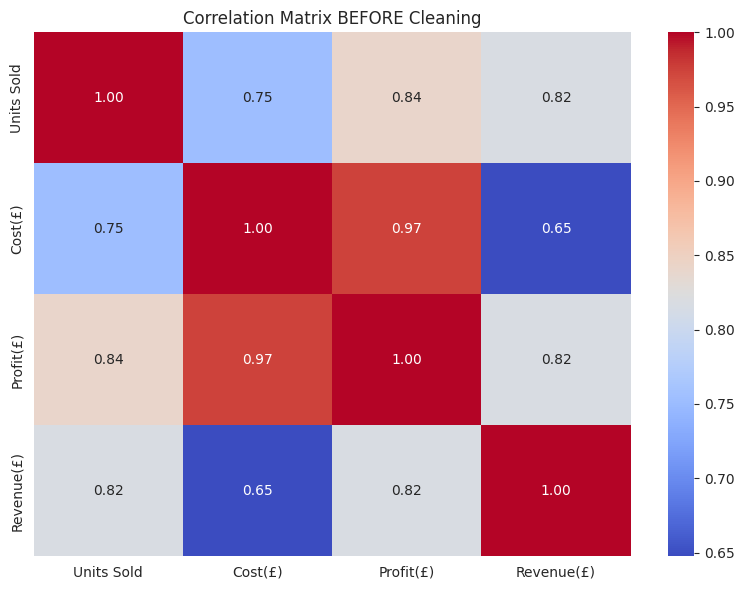

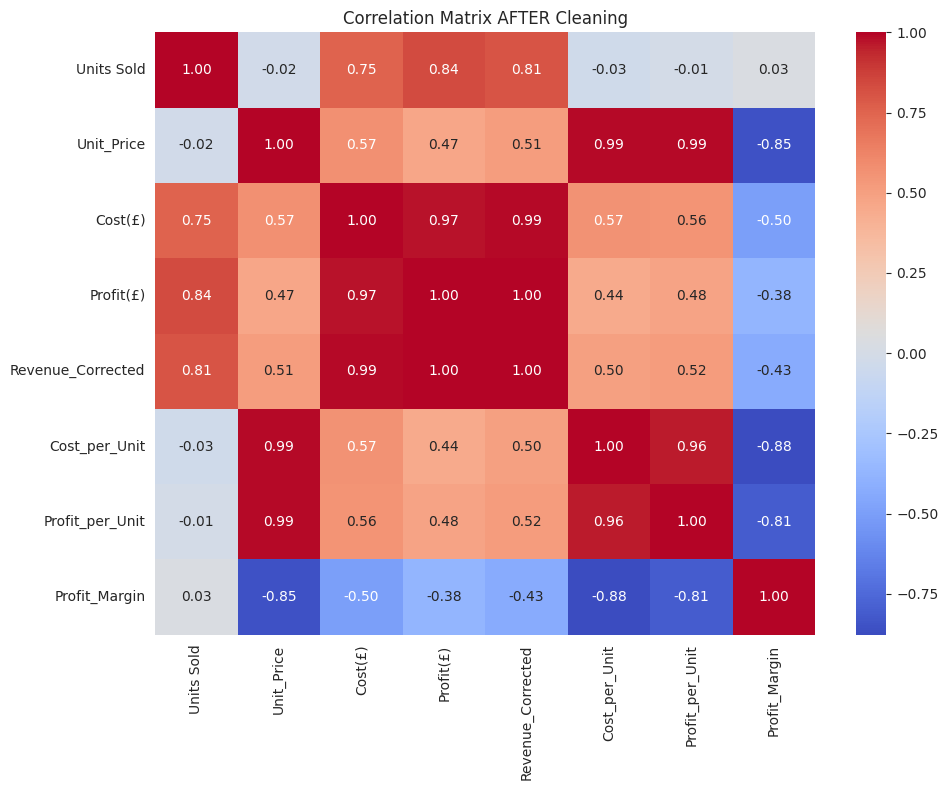

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Correlation Heatmap BEFORE Cleaning
numcols_raw = ['Units Sold', 'Cost(£)', 'Profit(£)', 'Revenue(£)']
corr_raw = df_raw[numcols_raw].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix BEFORE Cleaning")
plt.tight_layout()
plt.show()

# 2. Correlation Heatmap AFTER Cleaning
numcols_cleaned = ['Units Sold', 'Unit_Price', 'Cost(£)', 'Profit(£)', 'Revenue_Corrected', 'Cost_per_Unit', 'Profit_per_Unit', 'Profit_Margin']
corr_cleaned = df[numcols_cleaned].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cleaned, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix AFTER Cleaning")
plt.tight_layout()
plt.show()

# Task
Enhance the static plots in Cell 7 by applying improved color palettes and visual aesthetics, ensuring better readability and visual appeal, using specific Seaborn palettes and colormaps.

## Enhance Static Plots in Cell 7

### Subtask:
Modify Cell 7 to apply improved color palettes and visual aesthetics to all static Matplotlib/Seaborn plots, ensuring better readability and visual appeal, using specific Seaborn palettes and colormaps.


**Reasoning**:
The subtask requires modifying Cell 7 to apply improved color palettes and visual aesthetics to all static Matplotlib/Seaborn plots as per the instructions. This involves updating the plotting calls with specific color and palette arguments.



In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming OUT_DIR is already defined from Cell 1
# sns.set_style("whitegrid") is also set in Cell 1

plt.rcParams.update({'figure.max_open_warning': 0})

# 1. Units Sold distribution
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(df["Units Sold"], bins=40, kde=True, ax=ax, color='skyblue') # Added specific color
ax.set_title("Distribution of Units Sold")
fig.savefig(os.path.join(OUT_DIR,"units_sold_hist.png"), bbox_inches="tight")
plt.close(fig)

# 2. Profit margin by product (boxplot)
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x="Confectionary", y="Profit_Margin", ax=ax, palette='viridis') # Added specific palette
ax.set_title("Profit Margin by Product Type")
plt.xticks(rotation=45)
fig.savefig(os.path.join(OUT_DIR,"profit_margin_box.png"), bbox_inches="tight")
plt.close(fig)

# 3. Revenue by country (bar)
# Convert pandas plot to Seaborn barplot and use 'mako' palette
country_rev_df = df.groupby("Country(UK)")["Revenue_Corrected"].sum().sort_values().reset_index()
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=country_rev_df, x="Country(UK)", y="Revenue_Corrected", ax=ax, palette='mako') # Changed to sns.barplot with palette
ax.set_title("Total Corrected Revenue by Country")
ax.set_ylabel("Revenue (£)")
plt.xticks(rotation=45) # Ensure x-axis labels are rotated
fig.savefig(os.path.join(OUT_DIR,"rev_by_country.png"), bbox_inches="tight")
plt.close(fig)

# 4. Monthly time series (units sold)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
monthly = df.set_index("Date").resample("M")["Units Sold"].sum().dropna()
fig, ax = plt.subplots(figsize=(12,4))
monthly.plot(ax=ax, color='dodgerblue') # Added specific line color
ax.set_title("Monthly Units Sold")
fig.savefig(os.path.join(OUT_DIR,"units_sold_monthly.png"), bbox_inches="tight")
plt.close(fig)

# 5. Correlation heatmap
numcols = ["Units Sold","Unit_Price","Cost(£)","Profit(£)","Revenue_Corrected","Profit_Margin"]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df[numcols].corr(), annot=True, fmt=".2f", ax=ax, cmap='coolwarm') # Added specific colormap
ax.set_title("Correlation Matrix")
fig.savefig(os.path.join(OUT_DIR,"corr_heatmap.png"), bbox_inches="tight")
plt.close(fig)

print("Saved plots with enhanced aesthetics into outputs/")

/tmp/ipython-input-40169476.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-40169476.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-40169476.py:38: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Saved plots with enhanced aesthetics into outputs/


**Reasoning**:
The previous code generated `FutureWarning` messages from Seaborn about `palette` usage without `hue` and a Pandas `FutureWarning` about `resample('M')`. To address these, I will modify the `sns.boxplot` and `sns.barplot` calls to include the `hue` argument and `legend=False`, and update `resample('M')` to `resample('ME')` to ensure compliance with newer library versions and suppress the warnings.



In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming OUT_DIR is already defined from Cell 1
# sns.set_style("whitegrid") is also set in Cell 1

plt.rcParams.update({'figure.max_open_warning': 0})

# 1. Units Sold distribution
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(df["Units Sold"], bins=40, kde=True, ax=ax, color='skyblue') # Added specific color
ax.set_title("Distribution of Units Sold")
fig.savefig(os.path.join(OUT_DIR,"units_sold_hist.png"), bbox_inches="tight")
plt.close(fig)

# 2. Profit margin by product (boxplot)
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df, x="Confectionary", y="Profit_Margin", ax=ax, hue="Confectionary", palette='viridis', legend=False) # Added specific palette and hue
ax.set_title("Profit Margin by Product Type")
plt.xticks(rotation=45)
fig.savefig(os.path.join(OUT_DIR,"profit_margin_box.png"), bbox_inches="tight")
plt.close(fig)

# 3. Revenue by country (bar)
# Convert pandas plot to Seaborn barplot and use 'mako' palette
country_rev_df = df.groupby("Country(UK)")["Revenue_Corrected"].sum().sort_values().reset_index()
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=country_rev_df, x="Country(UK)", y="Revenue_Corrected", ax=ax, hue="Country(UK)", palette='mako', legend=False) # Changed to sns.barplot with palette and hue
ax.set_title("Total Corrected Revenue by Country")
ax.set_ylabel("Revenue (£)")
plt.xticks(rotation=45) # Ensure x-axis labels are rotated
fig.savefig(os.path.join(OUT_DIR,"rev_by_country.png"), bbox_inches="tight")
plt.close(fig)

# 4. Monthly time series (units sold)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
monthly = df.set_index("Date").resample("ME")["Units Sold"].sum().dropna() # Changed 'M' to 'ME'
fig, ax = plt.subplots(figsize=(12,4))
monthly.plot(ax=ax, color='dodgerblue') # Added specific line color
ax.set_title("Monthly Units Sold")
fig.savefig(os.path.join(OUT_DIR,"units_sold_monthly.png"), bbox_inches="tight")
plt.close(fig)

# 5. Correlation heatmap
numcols = ["Units Sold","Unit_Price","Cost(£)","Profit(£)","Revenue_Corrected","Profit_Margin"]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df[numcols].corr(), annot=True, fmt=".2f", ax=ax, cmap='coolwarm') # Added specific colormap
ax.set_title("Correlation Matrix")
fig.savefig(os.path.join(OUT_DIR,"corr_heatmap.png"), bbox_inches="tight")
plt.close(fig)

print("Saved plots with enhanced aesthetics into outputs/")

Saved plots with enhanced aesthetics into outputs/


## Enhance Plotly Preview in Cell 8

### Subtask:
Update the interactive Plotly bar chart in Cell 8 to use a more visually appealing and consistent color scheme, utilizing Plotly Express's color options.


**Reasoning**:
To enhance the Plotly bar chart in Cell 8, I will modify the `px.bar` function call to color the bars by 'Confectionary' and apply a `color_discrete_sequence` for improved visual appeal, as per the instructions.



In [54]:
# Cell 8: Simple interactive Plotly preview (optional)
fig = px.bar(df.groupby("Confectionary")["Revenue_Corrected"].sum().reset_index(),
             x="Confectionary", y="Revenue_Corrected", title="Revenue by Product (Corrected)",
             color="Confectionary", color_discrete_sequence=px.colors.sequential.Viridis)
fig.show()

## Enhance Dash App Plots in Cell 9

### Subtask:
Revise the Dash application code in Cell 9 to incorporate improved color palettes and visual styling for all Plotly Express charts (bar, line, box plots) within the dashboard, ensuring a cohesive and professional look.


**Reasoning**:
To enhance the Dash app plots, I will modify the Dash application code in `Cell 9` to incorporate improved color palettes and visual styling for all Plotly Express charts as per the instructions, then write the updated code to `outputs/app.py`.



In [55]:
dash_code = r'''
# app.py - run with `python app.py`
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd

df = pd.read_csv("outputs/Confectionary_cleaned.csv", parse_dates=["Date"])
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Confectionary Sales Dashboard"),
    dcc.Dropdown(id="country", options=[{"label":c,"value":c} for c in sorted(df["Country(UK)"].unique())],
                 value=sorted(df["Country(UK)"].unique())[0]),
    dcc.Graph(id="rev_by_product"),
    dcc.Graph(id="units_ts"),
    dcc.Graph(id="margin_box")
])

@app.callback(
    Output("rev_by_product","figure"),
    Output("units_ts","figure"),
    Output("margin_box","figure"),
    Input("country","value")
)
def update(country):
    dff = df[df["Country(UK)"]==country]
    fig1 = px.bar(dff.groupby("Confectionary")["Revenue_Corrected"].sum().reset_index(),
                  x="Confectionary", y="Revenue_Corrected", title=f"Revenue by Product in {country}",
                  color="Confectionary", color_discrete_sequence=px.colors.sequential.Viridis)
    ts = dff.set_index("Date").resample("ME")["Units Sold"].sum().reset_index()
    fig2 = px.line(ts, x="Date", y="Units Sold", title=f"Units Sold Over Time in {country}",
                   color_discrete_sequence=[px.colors.sequential.Plasma[0]]) # Using first color from Plasma for single line
    fig3 = px.box(dff, x="Confectionary", y=(dff["Profit(£)"]/dff["Revenue_Corrected"]).values, title="Profit Margin by Product",
                  color="Confectionary", color_discrete_sequence=px.colors.sequential.Cividis)
    fig3.update_layout(yaxis_title="Profit Margin") # Added y-axis title for clarity
    return fig1, fig2, fig3

if __name__ == "__main__":
    app.run(debug=True, port=8050)
'''
with open(os.path.join(OUT_DIR,"app.py"), "w") as f:
    f.write(dash_code)
print("Dash app skeleton written to outputs/app.py with enhanced styles.")

Dash app skeleton written to outputs/app.py with enhanced styles.


**Reasoning**:
Now that the Dash application code has been updated in `outputs/app.py` with enhanced styling, the next step is to execute this file to restart the Dash application with the new configurations.



In [ ]:
!python /content/outputs/app.py

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app 'app'
 * Debug mode: on
